In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from DS_healpix_fragmentation import radec2pix
from DS_Planck_Unet import val_pix
import warnings
from astropy.io import fits
from astropy.table import Table 
warnings.filterwarnings("ignore")

In [2]:
def match_m500_z(cat, true_cats, pixels=None, match_dist=0.5/60, del_fp=True):
    import pandas as pd
    import numpy as np
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    from DS_healpix_fragmentation import radec2pix
    
    cat.index = np.arange(len(cat))
    if del_fp:
        cat = cat[cat['status'] != 'fp']
        cat.index = np.arange(len(cat))
    
    if not (pixels is None):
        cat['pix2'] = radec2pix(cat['RA'], cat['DEC'], 2)
        cat = cat[np.in1d(cat['pix2'], pixels)]
        cat.index = np.arange(len(cat))
    
    cat['M500'] = 0.0
    cat['z'] = 0.0
    cat['tRA'][cat['status'] == 'fn'] = cat['RA'][cat['status'] == 'fn']
    cat['tDEC'][cat['status'] == 'fn'] = cat['DEC'][cat['status'] == 'fn']
    
    cat_sc = SkyCoord(ra=np.array(cat['tRA'])*u.degree, 
                      dec=np.array(cat['tDEC'])*u.degree, frame='icrs')
    
    for cat_name in true_cats:
        true_sc = SkyCoord(ra=np.array(true_cats[cat_name]['RA'])*u.degree, 
                           dec=np.array(true_cats[cat_name]['DEC'])*u.degree, frame='icrs')
        
        idx, d2d, _ = cat_sc.match_to_catalog_sky(true_sc)
        matched = d2d.degree < match_dist
        m_count = np.count_nonzero(np.logical_xor(cat['catalog'] == cat_name, matched))
        if m_count > 0:
            print(cat_name, m_count, 'not matched')
        cat['M500'].iloc[matched] = np.array(true_cats[cat_name]['M500'][idx[matched]])
        cat['z'].iloc[matched] = np.array(true_cats[cat_name]['z'][idx[matched]])
    return cat

In [3]:
cat_pz = pd.read_csv('/home/rt2122/Data/scans_old/scans_extended/connected/ep14_thr0.1.csv')
cat_pz_act = pd.read_csv('/home/rt2122/Data/detected_cats/c_act_ep11_val_st8_thr.1.csv')

In [4]:
true_cats = {}
true_cats['planck_z'] = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')
true_cats['planck_no_z'] = pd.read_csv('/home/rt2122/Data/clusters/planck_no_z.csv')
true_cats['mcxcwp'] = pd.read_csv('/home/rt2122/Data/clusters/mcxcwp.csv')
true_cats['act'] = pd.read_csv('/home/rt2122/Data/clusters/act.csv')

In [5]:
print(cat_pz.shape)
cat_pz = match_m500_z(cat_pz, true_cats, val_pix)
print(cat_pz.shape)
print(cat_pz_act.shape)
cat_pz_act = match_m500_z(cat_pz_act, true_cats, val_pix)
print(cat_pz_act.shape)

(22394, 12)
(792, 15)
(2018, 12)
(792, 15)


In [7]:
print('pz val recall ' + str(np.count_nonzero(cat_pz['status'] == 'tp') / len(cat_pz)))
print('pz_act val recall ' + str(np.count_nonzero(cat_pz_act['status'] == 'tp') / len(cat_pz_act)))

pz val recall 0.28535353535353536
pz_act val recall 0.29924242424242425


In [9]:
cat_pz.to_csv('/home/rt2122/Data/cur/pz_val_ep14_t0.1_nofp_mz.csv')
cat_pz_act.to_csv('/home/rt2122/Data/cur/pz_act_val_ep14_t0.1_nofp_mz.csv')

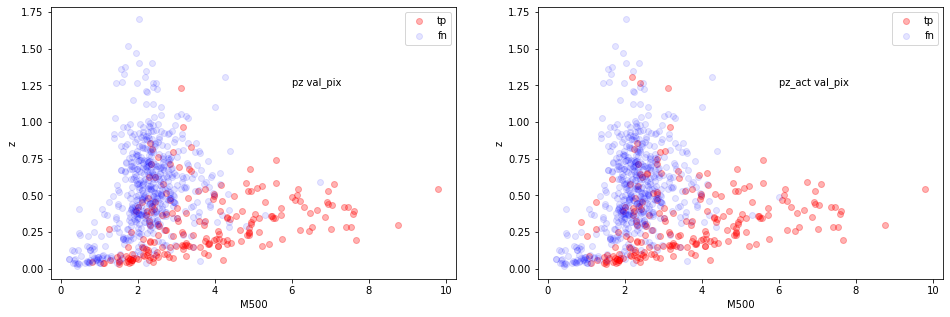

In [15]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, name, cat in zip([0, 1], ['pz', 'pz_act'], [cat_pz, cat_pz_act]):
    tp = cat[cat['status'] == 'tp']
    fn = cat[cat['status'] == 'fn']
    tp = tp[tp['z'] != -1]
    fn = fn[fn['z'] != -1]
    s = ax[i].scatter(tp['M500'], tp['z'], c='r', alpha=0.3)
    s.set_label('tp')
    s = ax[i].scatter(fn['M500'], fn['z'], c='b', alpha=0.1)
    s.set_label('fn')
    ax[i].set_xlabel('M500')
    ax[i].set_ylabel('z')
    ax[i].text(6, 1.25, name+' val_pix')
    ax[i].legend()

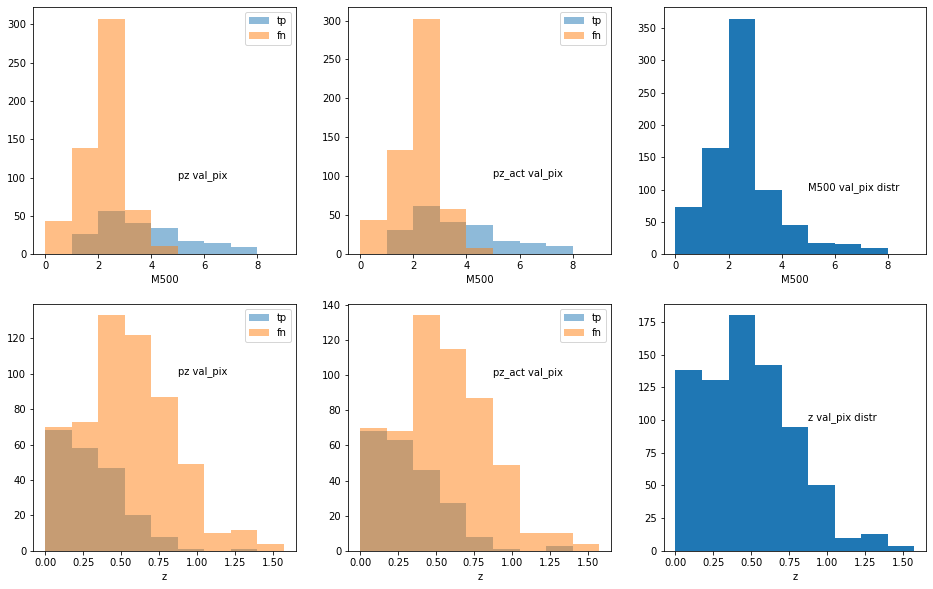

In [30]:
n_bins=10

_, ax = plt.subplots(2, 3, figsize=(16, 10))
for i, name, cat in zip([0, 1], ['pz', 'pz_act'], [cat_pz, cat_pz_act]):
    tp = cat[cat['status'] == 'tp']
    fn = cat[cat['status'] == 'fn']
    tp = tp[tp['z'] != -1]
    fn = fn[fn['z'] != -1]
    for j, prm, max_v in zip([0, 1], ['M500', 'z'], [10, 1.75]):
        bins = np.arange(0, max_v, max_v / n_bins)
        h = ax[j][i].hist(tp[prm], bins, alpha=0.5, label='tp')
        h = ax[j][i].hist(fn[prm], bins, alpha=0.5, label='fn')
        ax[j][i].set_xlabel(prm)
        ax[j][i].text(0.5*max_v, 100, name+' val_pix')
        ax[j][i].legend()
for j, prm, max_v in zip([0, 1], ['M500', 'z'], [10, 1.75]):
    bins = np.arange(0, max_v, max_v / n_bins)
    ax[j][2].hist(cat_pz[prm], bins)
    ax[j][2].set_xlabel(prm)
    ax[j][2].text(0.5*max_v, 100, prm+' val_pix distr')

In [31]:
def recall_by_cat(df, cat_name):
    import numpy as np
    
    cur_df = df[df['catalog'] == cat_name]
    return np.count_nonzero(cur_df['status'] == 'tp') / len(cur_df)

In [34]:
recall = []
for name, df in zip(['pz', 'pz_act'], [cat_pz, cat_pz_act]):
    line = {}
    for cat_name in true_cats:
        line[cat_name] = recall_by_cat(df, cat_name)
    recall.append(pd.DataFrame(line, index=[name]))
recall = pd.concat(recall)
recall

,planck_z,planck_no_z,mcxcwp,act
pz,0.931818,0.821429,0.155340,0.120983
pz_act,0.939394,0.750000,0.174757,0.139887


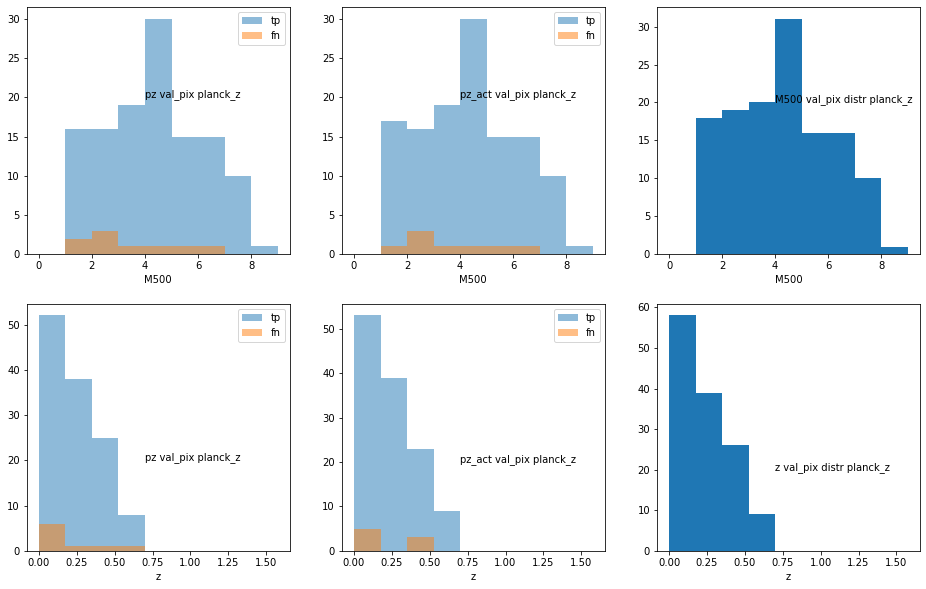

In [42]:
n_bins=10

_, ax = plt.subplots(2, 3, figsize=(16, 10))
for i, name, cat in zip([0, 1], ['pz', 'pz_act'], [cat_pz, cat_pz_act]):
    tp = cat[cat['status'] == 'tp']
    fn = cat[cat['status'] == 'fn']
    tp.index = np.arange(len(tp))
    tp = tp[tp['catalog'] == 'planck_z']
    fn.index = np.arange(len(fn))
    fn = fn[fn['catalog'] == 'planck_z']
    tp = tp[tp['z'] != -1]
    fn = fn[fn['z'] != -1]
    for j, prm, max_v in zip([0, 1], ['M500', 'z'], [10, 1.75]):
        bins = np.arange(0, max_v, max_v / n_bins)
        h = ax[j][i].hist(tp[prm], bins, alpha=0.5, label='tp')
        h = ax[j][i].hist(fn[prm], bins, alpha=0.5, label='fn')
        ax[j][i].set_xlabel(prm)
        ax[j][i].text(0.4*max_v, 20, name+' val_pix planck_z')
        ax[j][i].legend()
for j, prm, max_v in zip([0, 1], ['M500', 'z'], [10, 1.75]):
    cur_df = cat_pz[cat_pz['catalog'] == 'planck_z']
    bins = np.arange(0, max_v, max_v / n_bins)
    ax[j][2].hist(cur_df[prm], bins)
    ax[j][2].set_xlabel(prm)
    ax[j][2].text(0.4*max_v, 20, prm+' val_pix distr planck_z')

In [19]:
true_cats = {}
with fits.open('/home/rt2122/Data/original_catalogs/psz2.fits') as hdul:
    data = hdul[1].data
    true_cats['PSZ2'] = Table(data).to_pandas()
with fits.open('/home/rt2122/Data/original_catalogs/mcxc.fits') as hdul:
    data = hdul[1].data
    true_cats['MCXC'] = Table(data).to_pandas()
with fits.open('/home/rt2122/Data/original_catalogs/act.fits') as hdul:
    data = hdul[1].data
    true_cats['ACT'] = Table(data).to_pandas()
true_cats['PSZ2'].rename({'REDSHIFT' : 'z', 'MSZ' : 'M500'}, axis='columns', inplace=True)
true_cats['MCXC'].rename({'RAdeg' : 'RA', 'DEdeg' : 'DEC'}, axis='columns', inplace=True)
true_cats['ACT'].rename({'RADeg' : 'RA', 'decDeg' : 'DEC', 'redshift' : 'z'}, axis='columns', inplace=True)

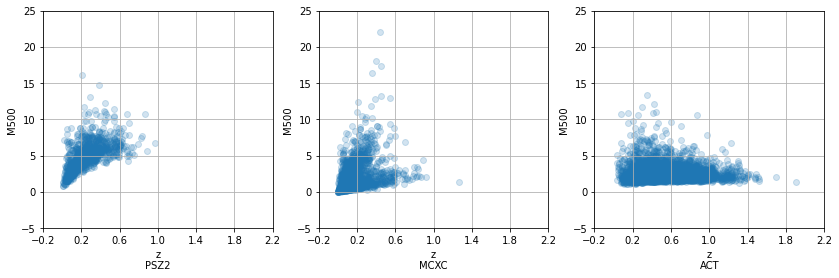

In [21]:
_, ax = plt.subplots(1, 3, figsize=(14, 4))
coords = {'PSZ2' : [0.8, 4], 'MCXC' : [1, 5], 'ACT' : [1.5, 4]}
for i, cat in enumerate(true_cats):
    true_cats[cat] = true_cats[cat][true_cats[cat] != -1]
    ax[i].scatter(true_cats[cat]['z'], true_cats[cat]['M500'], alpha=0.2)
    ax[i].set_xlabel('z'+ '\n'+cat)
    ax[i].set_ylabel('M500')
    ax[i].set_xticks(np.arange(-0.2, 2.2, 0.4))
    ax[i].set_yticks(np.arange(-5, 26, 5))
    ax[i].grid()

In [43]:
df = pd.read_csv('/home/rt2122/Data/detected_cats/full_pz25_thr0.1_step8.csv')
df = df[df['status'] != 'fn']
df.index = np.arange(len(df))

In [44]:
sc = SkyCoord(ra=np.array(df['RA'])*u.degree, dec=np.array(df['DEC'])*u.degree, frame='icrs')
for name in true_cats:
    tsc = SkyCoord(ra=np.array(true_cats[name]['RA'])*u.degree, 
                   dec=np.array(true_cats[name]['DEC'])*u.degree, 
                                            frame='icrs')
    idx, d2d, _ = sc.match_to_catalog_sky(tsc)
    matched = d2d.degree < (5 / 60)
    true_cats[name]['matched'] = False
    true_cats[name]['matched'].iloc[idx[matched]] = True

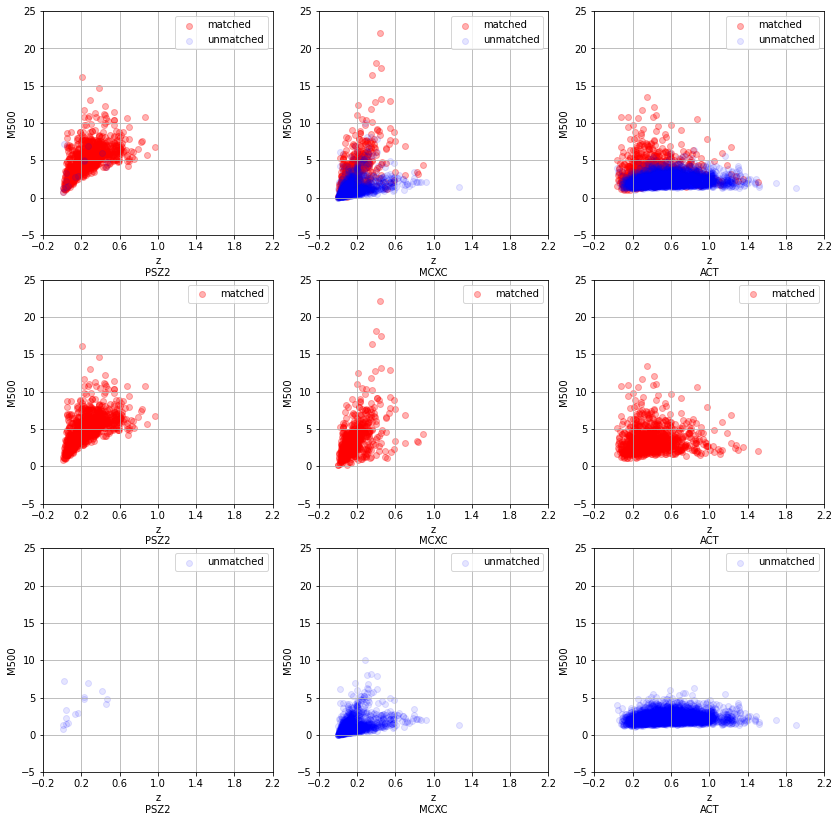

In [45]:
_, ax = plt.subplots(3, 3, figsize=(14, 14))
coords = {'PSZ2' : [0.8, 4], 'MCXC' : [1, 5], 'ACT' : [1.5, 4]}
for i, cat in enumerate(true_cats):
    true_cats[cat] = true_cats[cat][true_cats[cat] != -1]
    matched = true_cats[cat]
    matched = matched[matched['matched']]
    s = ax[0][i].scatter(matched['z'], matched['M500'], alpha=0.3, c='r')
    s.set_label('matched')
    s = ax[1][i].scatter(matched['z'], matched['M500'], alpha=0.3, c='r')
    s.set_label('matched')
    unmatched = true_cats[cat]
    unmatched = unmatched[unmatched['matched'] == False]
    s = ax[0][i].scatter(unmatched['z'], unmatched['M500'], alpha=0.1, c='b')
    s.set_label('unmatched')
    s = ax[2][i].scatter(unmatched['z'], unmatched['M500'], alpha=0.1, c='b')
    s.set_label('unmatched')
    for j in range(3):
        ax[j][i].set_xlabel('z'+ '\n'+cat)
        ax[j][i].set_ylabel('M500')
        ax[j][i].set_xticks(np.arange(-0.2, 2.2, 0.4))
        ax[j][i].set_yticks(np.arange(-5, 26, 5))
        ax[j][i].grid()
        ax[j][i].legend()

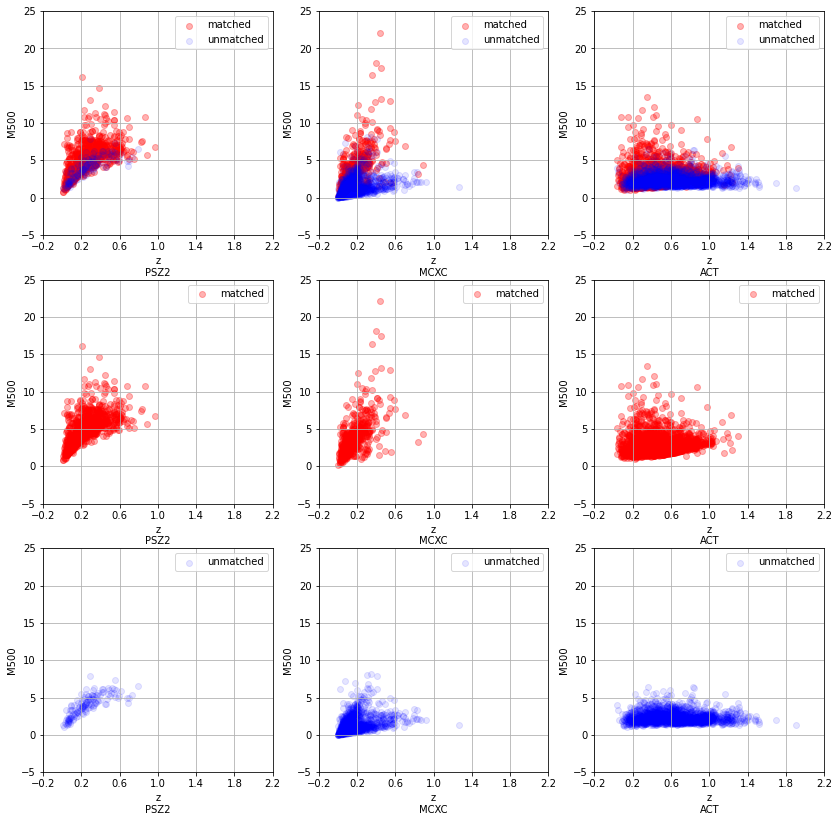

In [42]:
_, ax = plt.subplots(3, 3, figsize=(14, 14))
coords = {'PSZ2' : [0.8, 4], 'MCXC' : [1, 5], 'ACT' : [1.5, 4]}
for i, cat in enumerate(true_cats):
    true_cats[cat] = true_cats[cat][true_cats[cat] != -1]
    matched = true_cats[cat]
    matched = matched[matched['matched']]
    s = ax[0][i].scatter(matched['z'], matched['M500'], alpha=0.3, c='r')
    s.set_label('matched')
    s = ax[1][i].scatter(matched['z'], matched['M500'], alpha=0.3, c='r')
    s.set_label('matched')
    unmatched = true_cats[cat]
    unmatched = unmatched[unmatched['matched'] == False]
    s = ax[0][i].scatter(unmatched['z'], unmatched['M500'], alpha=0.1, c='b')
    s.set_label('unmatched')
    s = ax[2][i].scatter(unmatched['z'], unmatched['M500'], alpha=0.1, c='b')
    s.set_label('unmatched')
    for j in range(3):
        ax[j][i].set_xlabel('z'+ '\n'+cat)
        ax[j][i].set_ylabel('M500')
        ax[j][i].set_xticks(np.arange(-0.2, 2.2, 0.4))
        ax[j][i].set_yticks(np.arange(-5, 26, 5))
        ax[j][i].grid()
        ax[j][i].legend()